Implementation of the points generation procedure copied from Nicolas Rougier here:

https://github.com/rougier/recursive-voronoi

and originally by Johannes Dollinger, see https://github.com/emulbreh/bridson

The algorithm is described in this exerpt from the original paper:

The algorithm takes as input the extent of the sample domain in $R^n$, the minimum distancer between samples, and a constant `k`  as the limit of samples to choose before rejection in the algorithm (typically `k` = 30).

### Step 0.
Initialize an $n$-dimensional background grid for storing samples and accelerating spatial searches.

We pick the cell size to be bounded by $r/\sqrt{n}$, so that each grid cell will contain at most one sample, and thus the grid can be implemented as a simple $n$-dimensional array of integers: the default -1 indicates no sample, a non-negative integer gives the index of the sample located in a cell. 

### Step 1.

Select the initial sample, $x_0$, randomly chosen uniformly from the domain. Insert it into the background grid, and initialize the “active list” (an array of sample indices) with this index (zero).

### Step 2.

While the active list is not empty, choose a random index from it (say $i$). Generate up to `k` points chosen uniformly from the spherical annulus between radius $r$ and $2r$ around $x_i$. For each point in turn, check if it is within distance $r$ of existing samples (using the background grid to only test nearby samples). If a point is adequately far from existing samples, emit it as the next sample and add it to the active list. If after `k` attempts no such point is found, instead remove $i$ from the active list.


In [298]:
import numpy as np
from math import tau, cos, sin, sqrt, ceil, floor
from scipy.spatial import distance

import matplotlib.pyplot as plt

from tyssue.generation.shapes import sheet_from_cell_centers

In [303]:
def blue_noise(width, height, radius, periodic=False, metric="euclidiean", k=30, seed=None):    
    """
    Generate blue noise over a two-dimensional rectangle of size (width, height)
    Parameters
    ----------
    width, height : floats
        Two-dimensional domain (width x height) 
    radius : float
        Minimum distance between samples
    k : int, optional
        Limit of samples to choose before rejection (typically k = 30)
    seed : int, optional
        If provided, this will set the random seed before generating noise,
        for valid pseudo-random comparisons.
    References
    ----------
    .. [1] Fast Poisson Disk Sampling in Arbitrary Dimensions, Robert Bridson,
           Siggraph, 2007. :DOI:`10.1145/1278780.1278807`
    Implementation by Johannes Dollinger,
    see https://github.com/emulbreh/bridson

    .. [2] 
    http://kucg.korea.ac.kr/new/seminar/2006/src/PA-06-31.pdf

    """
    # When given a seed, we use a private random generator in order to not
    # disturb the default global random generator
    if seed is not None:
        from numpy.random.mtrand import RandomState
        rng = RandomState(seed=seed)
    else:
        rng = np.random


    grid_step = radius / sqrt(2)
    grid_shape = ceil(width/grid_step), ceil(height/grid_step)
    
    grid = -np.ones(grid_shape, dtype=int)
    points = []
    actives = []
    p0 = rng.random(size=2) * np.array([width, height])
    points.append(p0)
    actives.append(p0)
    i, j = np.floor(p0/grid_step).astype(int)
    
    grid[i, j] = 0
    n = 0
    N, M = grid.shape

    while actives:
        #rng.shuffle(actives)
        point = actives[-1]
        rhos = rng.uniform(radius, 4*radius, size=k)
        thetas = rng.uniform(0, tau, size=k)
        new_points = np.vstack([
                rhos * np.cos(thetas) + point[0],
                rhos * np.sin(thetas) + point[1]
        ]).T
        for new_point in new_points:
            i, j = np.floor(new_point/grid_step).astype(int)
            N, M = grid.shape
            if not ((0 <= i < N) and (0 <= j < M)):
                continue
            local = get_local(i, j, N, M, periodic=periodic, s=2)
            if fits(new_point, local, points, grid, radius, metric=metric):
                n += 1
                grid[i, j] = n
                actives.append(new_point)
                points.append(new_point)
                break
        else:
            actives.pop()
    return np.array(points)


def spherical_dist(u, v, r=1):
    
    theta1, phi1 = u
    theta2, phi2 = v
    dtheta, dphi = v - u

    dsigma = 2 * np.arcsin(
        np.sqrt(
            (
                np.sin(dphi/2)**2 
                + np.cos(phi1) * np.cos(phi2)
                * np.sin(dtheta/2)**2
            )
        )
    )
    return r*dsigma


def get_local(i, j, N, M, periodic=False, s=2):
    
    if not periodic:
        return (
            slice(max(i-s, 0), min(i+s+1, N)),
            slice(max(j-s, 0), min(j+s+1, M))
        )
    else:
        r_i = np.arange(i-s, i+s+1)
        r_i[r_i < 0] = r_i[r_i < 0] + N
        r_i[r_i >= N] = r_i[r_i >= N] - N

        r_j = np.arange(j-s, j+s+1)
        r_j[r_j < 0] = r_j[r_j < 0] + M
        r_j[r_j >= M] = r_j[r_j >= M] - M
        return tuple(np.meshgrid(r_i.ravel(), r_j.ravel()))
    
        
def fits(new_point, local, points, grid, radius, metric="euclidean"):

    neighbs = grid[local].flatten()
    if not neighbs.size:
        return False
    
    neighbs = neighbs[neighbs >= 0]
    if not neighbs.size:
        return True
    else:
        distances = distance.cdist(
            new_point[None, :], np.array(points)[neighbs], metric=metric)
        if distances.min() > radius:
            return True
        else:
            return False

In [319]:
k = 30

width, height = tau/2, tau

num_points = 600
area = 2 * tau

radius = np.sqrt(area / num_points)
points = blue_noise(width, height, radius, periodic=True, metric=spherical_dist)

In [ ]:
from 

In [320]:
points.shape


(431, 2)

In [321]:
print(radius)

0.14472025091165353


In [322]:
print(width, height)

3.141592653589793 6.283185307179586


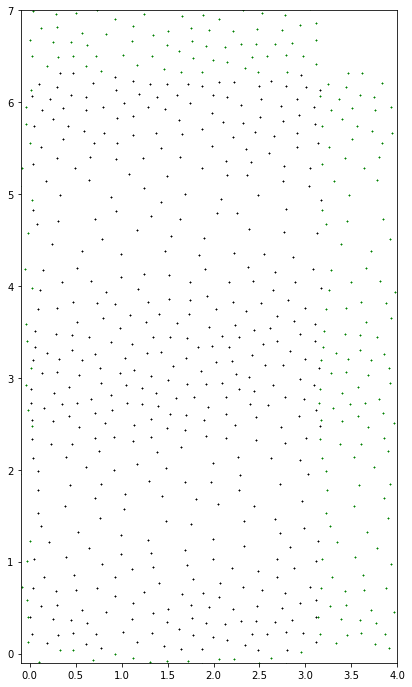

In [324]:


fig, ax = plt.subplots()

ax.plot(points[:, 0], points[:, 1], 'k+', ms=2)
ax.plot(points[:, 0], points[:, 1]+tau, 'g+', ms=2)
ax.plot(points[:, 0], points[:, 1]-tau, 'g+', ms=2)
ax.plot(points[:, 0]-tau/2, points[:, 1], 'g+', ms=2)
ax.plot(points[:, 0]+tau/2, points[:, 1], 'g+', ms=2)


ax.set_aspect('equal')
ax.set_xlim(-0.1, 4)
ax.set_ylim(-0.1, 7)
fig.set_size_inches(12, 12)

In [325]:

x = np.cos(points[:, 0]) * np.cos(points[:, 1])
y = np.sin(points[:, 0]) * np.cos(points[:, 1])
z = np.sin(points[:, 1])

In [326]:
import ipyvolume as ipv
ipv.clear()
ipv.scatter(x, y, z)
ipv.squarelim()
ipv.show()

In [327]:
sheet = sheet_from_cell_centers(np.vstack([x, y, z]).T)

In [328]:
from tyssue.draw import sheet_view
ipv.clear()
fig, mesh = sheet_view(sheet, mode="3D", face={"visible": True, "color": sheet.face_df["area"]})
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

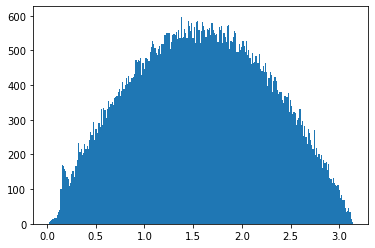

In [330]:
dists = distance.pdist(points, metric=spherical_dist)
H = plt.hist(dists, bins=256)

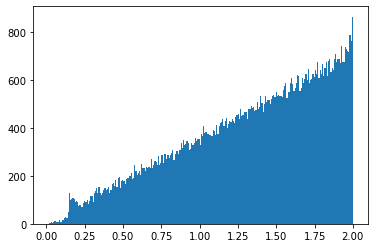

In [336]:
dists = distance.pdist(np.vstack([x, y, z]).T)
H = plt.hist(dists, bins=256)

In [344]:
distance.squareform(dists).shape

(431, 431)

In [338]:
points.shape

(431, 2)

In [ ]:
92665

In [343]:
(431 * 430) / 2

92665.0

In [75]:
from tyssue import ClosedSheetGeometry as sgeom
from tyssue import ClosedMonolayerGeometry as geom
from tyssue.solvers import QSSolver
from tyssue.generation import extrude
from tyssue.dynamics import effectors, model_factory


In [76]:
sgeom.update_all(sheet)

In [78]:
sheet.face_df.area.mean()

0.0551682108035031

In [80]:
for i in range(10):
    sgeom.scale(sheet, sheet.face_df.area.mean()**-0.5, coords=list('xyz'))
    sgeom.update_all(sheet)

print(sheet.face_df.area.mean())


1.0000000000000004


In [86]:
smodel = model_factory(
    [
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
        effectors.LineTension
    ]
)

specs = {
    "face" : {
        "area_elasticity": 1.0,
        "prefered_area": 1.0,
    },
    "edge" : {
        "line_tension": 1e-3
    },
    "settings": {
        "lumen_prefered_vol" : sheet.settings['lumen_vol'],
        "lumen_vol_elasticity" : 1e-4,
    }
}

sheet.update_specs(specs, reset=True)


Reseting column area_elasticity of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column line_tension of the edge dataset with new specs


In [87]:
solver = QSSolver()


In [89]:

res = solver.find_energy_min(sheet, sgeom, smodel)

In [90]:
from tyssue.draw import sheet_view
ipv.clear()
fig, mesh = sheet_view(sheet, mode="3D")
fig

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…